In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pickle
import json
import networkx as nx
import numpy as np
from netics import utils
import matplotlib.pyplot as plt

### Generate repetition code decoding graph 
- with arbitrary `code_distance` and `num_rounds`
- **circuit-level noise model**

In [2]:
with open('./bench/edge_weights.json', 'r') as f:
    weights = json.load(f)
d = 11
r = 20
g = utils.gene_rep_decoding_graph(d, r, **weights)

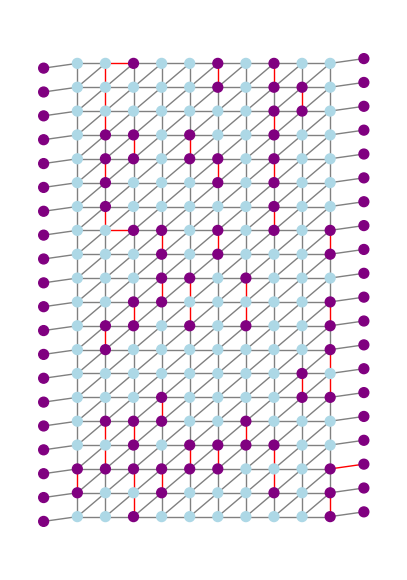

In [3]:
_ = utils.visualize_rep_decoding_graph(g, d, r)

### Comparison of `DistRepDecoder`, `GPURepDecoder` and `MonoRepDecoder`

#### Distributed decoding

In [4]:
import unionfind.distributed
import importlib
importlib.reload(unionfind.distributed)

decoder_dist = unionfind.distributed.DistRepDecoder(g, d, r)

In [5]:
decoder_dist.decode()

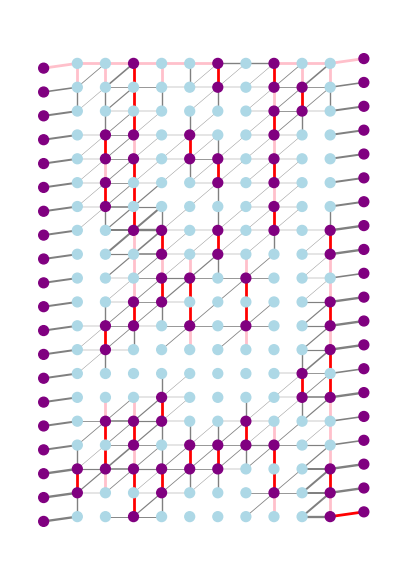

In [6]:
_ = decoder_dist.visualize_result_graph()

In [8]:
decoder_dist.guessed_error, decoder_dist.actual_error 

(Pauli('IIIIIIIIIZI'), Pauli('IIIIIIIIIZI'))

In [9]:
decoder_dist.num_inner_epochs

[14, 9, 12, 7, 38]

In [9]:
# calculate logical error rate
def sim_dist_logical_error_rate(num_iter, d, r):
    from tqdm import tqdm
    e = 0
    for _ in tqdm(range(num_iter)):
        g = utils.gene_rep_decoding_graph(d, r, **weights)  # change d and r
        decoder = unionfind.distributed.DistRepDecoder(g, d, r)
        decoder.decode()
        if decoder.logical_error:
            e += 1
    return e / num_iter / r

In [11]:
sim_dist_logical_error_rate(500, 11, 20)

100%|██████████| 500/500 [05:22<00:00,  1.55it/s]


0.0031

#### GPU decoding (using DGL library)

In [10]:
import unionfind.gpu
import importlib
import torch

importlib.reload(unionfind.gpu)
decoder_gpu = unionfind.gpu.GPURepDecoder(g, d, r)

In [11]:
decoder_gpu.decode()

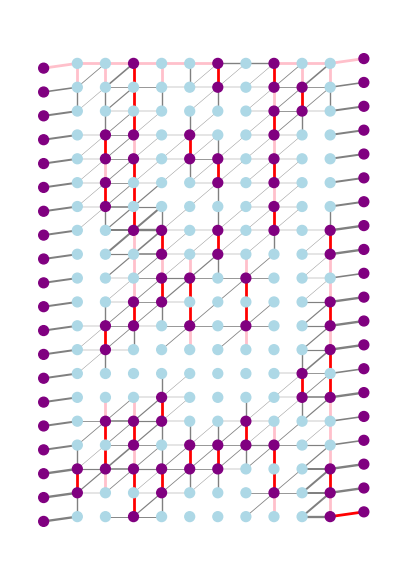

In [12]:
_ = decoder_gpu.visualize_result_graph()

In [13]:
decoder_gpu.guessed_error, decoder_gpu.actual_error 

(Pauli('IIIIIIIIIZI'), Pauli('IIIIIIIIIZI'))

In [14]:
decoder_gpu.logical_error

False

In [18]:
# calculate logical error rate
def sim_gpu_logical_error_rate(num_iter, d, r):
    from tqdm import tqdm
    e = 0
    for _ in tqdm(range(num_iter)):
        g = utils.gene_rep_decoding_graph(d, r, **weights)  # change d and r
        decoder = unionfind.gpu.GPURepDecoder(g, d, r)
        decoder.decode()
        if decoder.logical_error:
            e += 1
    return e / num_iter / r

In [23]:
# if there is no GPU, DGL-version distributed decoder has no advantage
sim_gpu_logical_error_rate(200, 11, 5)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [09:52<00:00,  2.96s/it]


0.008

#### Monolithic decoding

In [15]:
import unionfind.monolithic
import importlib
importlib.reload(unionfind.monolithic)

decoder_mono = unionfind.monolithic.MonoRepDecoder(g, d, r)

In [16]:
decoder_mono.decode()

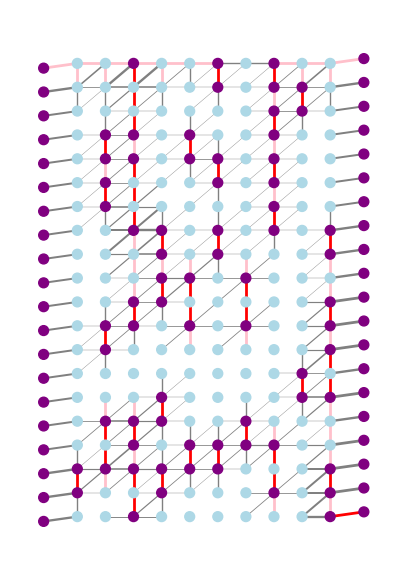

In [17]:
_ = decoder_mono.visualize_result_graph()

In [18]:
decoder_mono.num_epochs

5

In [25]:
# calculate logical error rate
def sim_mono_logical_error_rate(num_iter, d, r):
    from tqdm import tqdm
    e = 0
    for _ in tqdm(range(num_iter)):
        g = utils.gene_rep_decoding_graph(d, r, **weights)  # change d and r
        decoder = unionfind.monolithic.MonoRepDecoder(g, d, r)
        decoder.decode()
        if decoder.logical_error:
            e += 1
    return e / num_iter / r


In [27]:
sim_mono_logical_error_rate(500, 11, 20)

100%|██████████| 500/500 [00:11<00:00, 41.79it/s]


0.0031

In [21]:
sim_mono_logical_error_rate(100, 11, 100)

100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


0.001

In [22]:
sim_mono_logical_error_rate(50, 11, 200)

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


0.0008

### Summary

#### Logical error rate

In [21]:
num_iter = 500
d = 11
r = 100

In [22]:
p_mono = sim_mono_logical_error_rate(num_iter, d, r)
p_mono

100%|██████████| 500/500 [01:07<00:00,  7.43it/s]


0.0012

In [62]:
p_dist = sim_dist_logical_error_rate(num_iter, d, r)
p_dist

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [49:04<00:00,  5.89s/it] 


0.00116

In [ ]:
p_gpu = sim_gpu_logical_error_rate(num_iter, d, r)
p_gpu

#### Latency

In [35]:
d = 11
r = 100
from tqdm import tqdm
num_epochs_mono = []
num_epochs_dist = []
num_inner_epochs_dist = []
for _ in tqdm(range(100)):
    g = utils.gene_rep_decoding_graph(d, r, **weights)
    d_mono = unionfind.monolithic.MonoRepDecoder(g, d, r)
    d_mono.decode()
    d_dist = unionfind.distributed.DistRepDecoder(g, d, r)
    d_dist.decode()
    num_epochs_mono.append(d_mono.num_epochs)
    num_epochs_dist.append(len(d_dist.num_inner_epochs))
    num_inner_epochs_dist.append(np.mean(d_dist.num_inner_epochs))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [09:20<00:00,  5.60s/it]


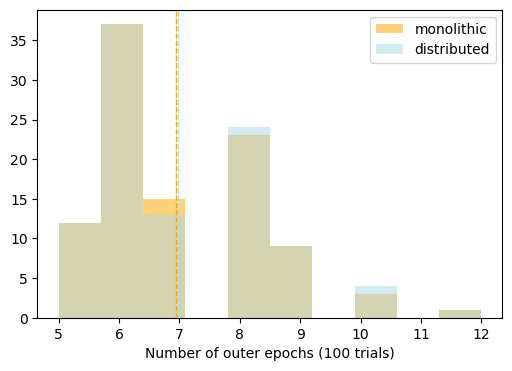

In [49]:
# distribution of num_epochs (comparison)
plt.figure(figsize=(6, 4))
plt.hist(num_epochs_mono, alpha=0.5, label='monolithic', color='orange')
plt.hist(num_epochs_dist, alpha=0.5, label='distributed', color='lightblue')
# draw the vline according to the mean
plt.axvline(np.mean(num_epochs_mono), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(num_epochs_dist), color='lightblue', linestyle='dashed', linewidth=1)
plt.legend(loc='upper right')
plt.xlabel('Number of outer epochs (100 trials)')
plt.show()

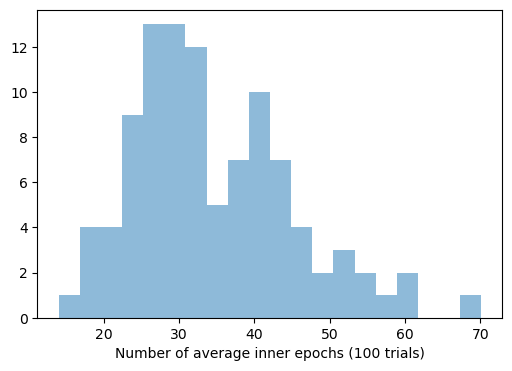

In [41]:
# distribution of num_inner_epochs (distributed)
plt.figure(figsize=(6, 4))
plt.hist(num_inner_epochs_dist, bins=20, alpha=0.5)
plt.xlabel('Number of average inner epochs (100 trials)')
plt.show()

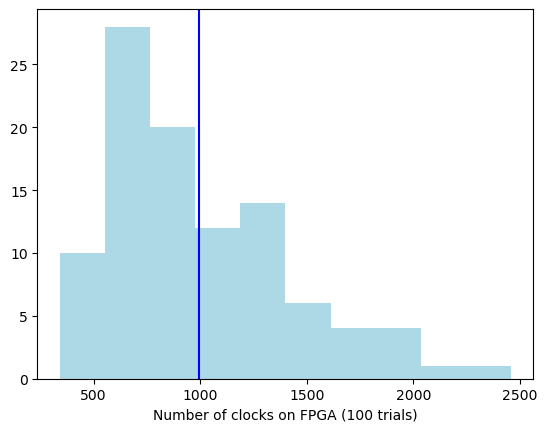

In [61]:
num_clocks = 4 * np.array(num_inner_epochs_dist) * np.array(num_epochs_dist) + np.array(num_epochs_dist)
plt.hist(num_clocks, color='lightblue')
plt.xlabel('Number of clocks on FPGA (100 trials)')
plt.axvline(x=np.mean(num_clocks), color='blue', label='Mean')
plt.show()

In [64]:
np.max(num_clocks)

2458.0

In [67]:
np.mean(num_inner_epochs_dist)

34.50696825396825